<a href="https://colab.research.google.com/github/duvancatan/Time_Series_UdeA/blob/main/10_Forecast_Redes_Neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PRONÓSTICOS CON REDES NEURONALES**

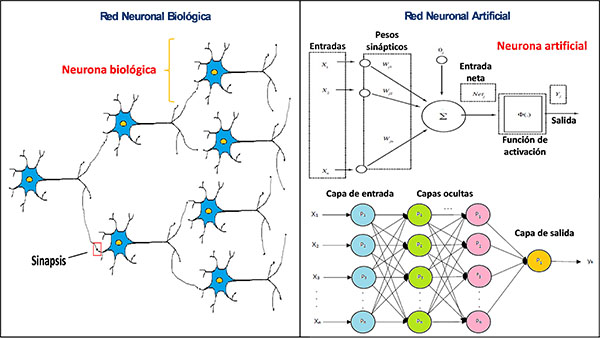

# Pronóstico del Número de Enfermedades Cardiovasculares

Los datos descritos en cmort, de la librería astsa, son series extraídas de un estudio de Shumway sobre los posibles efectos de la contaminación en la mortalidad cardiovascular semanal promedio en el condado de Los Ángeles a lo largo de los 10 años. Hay 508 promedios suavizados de seis días obtenidos al filtrar los valores diarios durante el período de 10 años 1970 - 1979.

## Instalación y carga de librerías  

In [ ]:
# Instalación de la librería statsmodels #
!pip install statsmodels

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd

## Lectura de datos


In [ ]:
# Lectura de datos
cmort_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cmort.csv', header=0, index_col=0)

In [ ]:
# Formato y rango temporal #
cmort_df.index = pd.date_range(start='1973-01-01', periods=len(cmort_df), freq='W-MON')
# Renombrar una columna
cmort_df = cmort_df.rename(columns={'x': 'num_die'})
cmort_df

,num_die
1973-01-01,97.85
1973-01-08,104.64
1973-01-15,94.36
1973-01-22,98.05
1973-01-29,95.85
...,...
1982-08-23,79.03
1982-08-30,76.56
1982-09-06,78.52
1982-09-13,89.43


## Análisis Exploratorio

In [ ]:
# Estadísticas Descriptivas #
cmort_df.describe()

,num_die
count,508.000000
mean,88.698878
std,9.998688
min,68.110000
25%,81.900000
50%,87.330000
75%,94.360000
max,132.040000


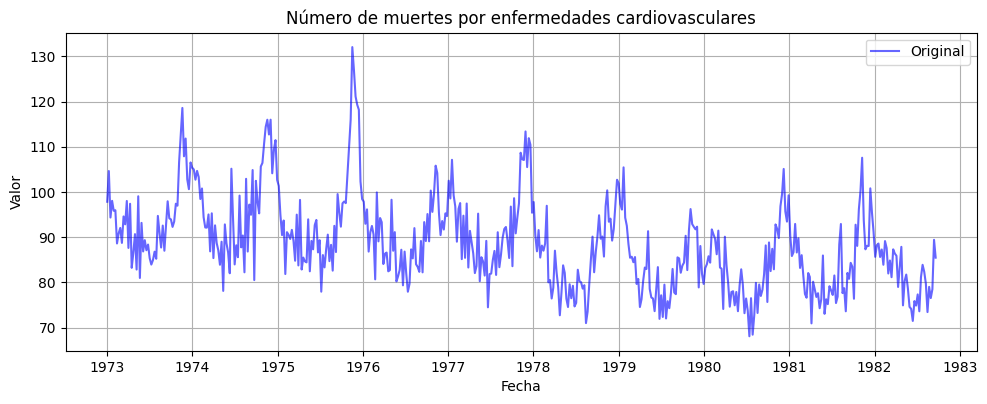

In [ ]:
# Configurando el tamaño del gráfico
plt.figure(figsize=(10, 15))

# Lista de variables para iterar y graficar
variables = ['num_die']

for i, var in enumerate(variables, 1):
    plt.subplot(4, 1, i)
    plt.plot(cmort_df.index, cmort_df[var], label=f'Original', color='blue', alpha=0.6)
    plt.title('Número de muertes por enfermedades cardiovasculares')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# Funciones ACF y PACF #
def acf_plot(z):
    acf_data = acf(z, fft=False, nlags = len(z)/4)
    plt.stem(range(len(acf_data)),acf_data, use_line_collection=True)
    plt.ylim(-1,1),
    plt.grid()

def pacf_plot(z):
    pacf_data = pacf(z, nlags = len(z)/4)
    plt.stem(range(len(pacf_data)),pacf_data, use_line_collection=True)
    plt.ylim(-1,1),
    plt.grid()

<ipython-input-7-7af4464a9597>:4: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(len(acf_data)),acf_data, use_line_collection=True)


Text(0.5, 1.0, 'ACF del Número de muertes')

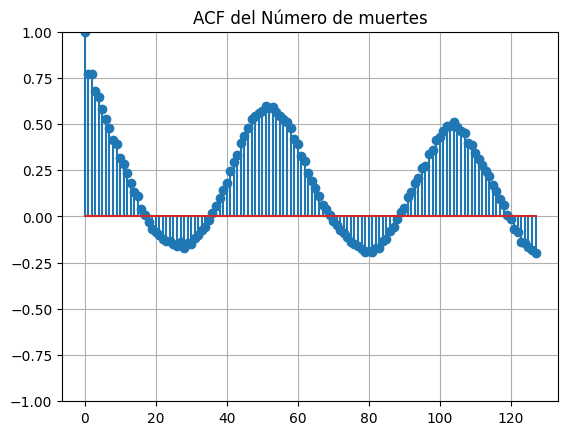

In [ ]:
acf_plot(cmort_df)
plt.title('ACF del Número de muertes')

<ipython-input-7-7af4464a9597>:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(len(pacf_data)),pacf_data, use_line_collection=True)


Text(0.5, 1.0, 'PACF del Número de muertes')

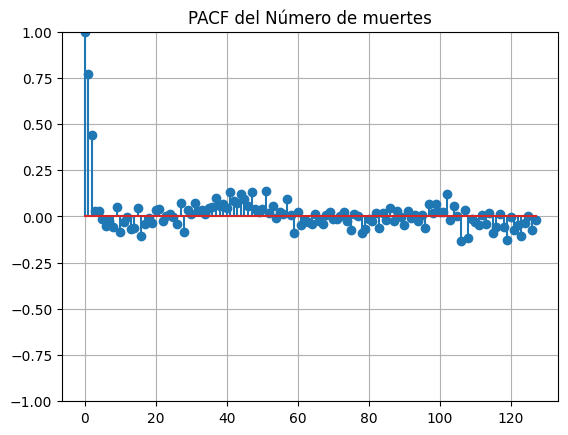

In [ ]:
pacf_plot(cmort_df)
plt.title('PACF del Número de muertes')

## Observación:

Se puede notar tanto de la ACF como de la PACF, que existe un patrón cíclico cada 52 semanas (1 año aproximadamente), motivo por el cual consideramos $S=52$

### **Existen dos métodos para modelar series usando una red neuronal artificial:**

1. Usando directamente las datos de la serie y dejar que el modelo capture tanto la tendencia como la estacionalidad.

2. Remover la tendencia y periodicidad, y la serie obtenida es empleada para pronosticar usando el modelos de redes neuronales artificiales.

# Modelo 1 : Pronósticos sin transformaciones

En este caso consideraremos $S=52$, aunque en la práctica deberían considerarse diversos valores de $S.$

In [ ]:
# Escalamos la series en el intervalo [0,1], para facilitar entrenamiento #
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Creación del transformador #
scaler = MinMaxScaler()

In [ ]:
# Escalamiento de la serie #
cmort_df_scaled = scaler.fit_transform(np.array(cmort_df).reshape(-1,1))

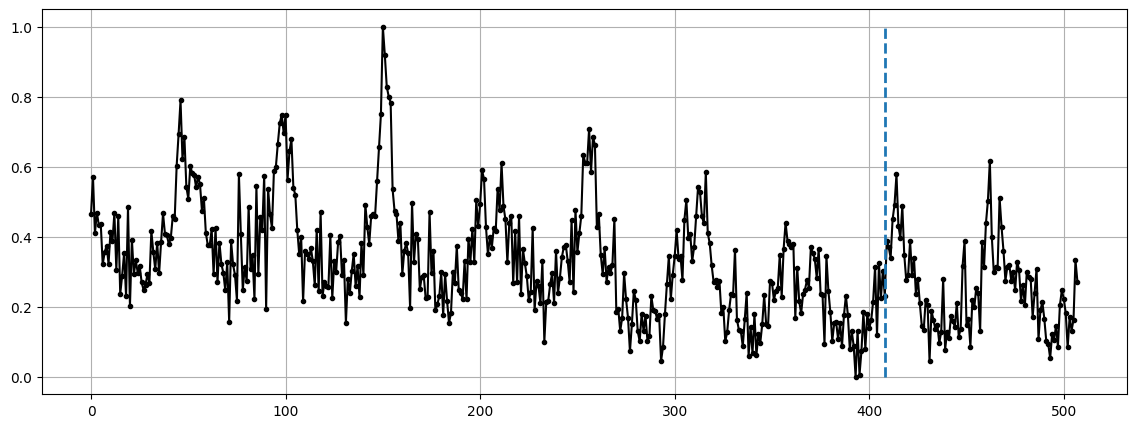

In [ ]:
# cmort_df_scaled es un array de listas como efecto del escalamiento #
cmort_df_scaled = [u[0] for u in cmort_df_scaled]

plt.figure(figsize=(14,5))
plt.plot(cmort_df_scaled, ".-k")
plt.grid()
plt.plot(
    [len(cmort_df_scaled)- 100, len(cmort_df_scaled)- 100],
    [min(cmort_df_scaled), max(cmort_df_scaled)],
    "--",
    linewidth=2,
);

Dado que la implementación disponible en $skalearn$ es para modelos de regresión, se debe estructurar una matriz donde las variables explicativas son $x_{t-1}, x_{t-2}, \ldots, x_{t-S}$ y la variable dependiente $x_{t}$

In [ ]:
S = 53

X = []
for t in range(S-1, 508 - 1):
  X.append([cmort_df_scaled[t-n] for n in range(S)])

observed_scaled = cmort_df_scaled[S:]

In [ ]:
# Número total de patrones al convertir las datos a un modelo de regresión #
len(X)

455

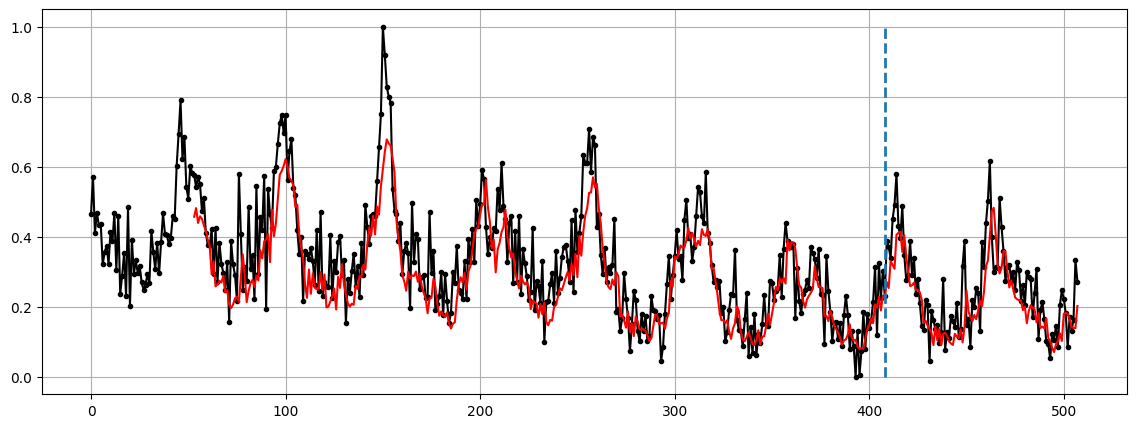

In [ ]:
from sklearn.neural_network import MLPRegressor

#np.random.seed(12356)

H = 1 # Valor arbitrario

mlp = MLPRegressor(
    hidden_layer_sizes=(H,),
    activation="logistic",
    learning_rate="adaptive",
    momentum=0.0,
    learning_rate_init=0.1,
    max_iter=10000
);

# Entrenamiento #
mlp.fit(X[0:355], observed_scaled[0:355]);  # 455 - 100 = 355

# Pronóstico #
y_scaled_m1 = mlp.predict(X);

# Gráfico #
plt.figure(figsize=(14,5))
plt.plot(cmort_df_scaled, ".-k")
plt.grid()

# No hay pronóstico de los 53 primero valores #
plt.plot([None] * S + y_scaled_m1.tolist(), "-r")

# Línea vertical para dividir el entrenamiento del pronóstico. Se ubica en el último dato usando para entrenamiento #
plt.plot(
    [len(cmort_df_scaled)- 100, len(cmort_df_scaled)- 100],
    [min(cmort_df_scaled), max(cmort_df_scaled)],
    "--",
    linewidth=2,
);

Text(0.5, 1.0, 'Series Original y Pronósticos Desescalados')

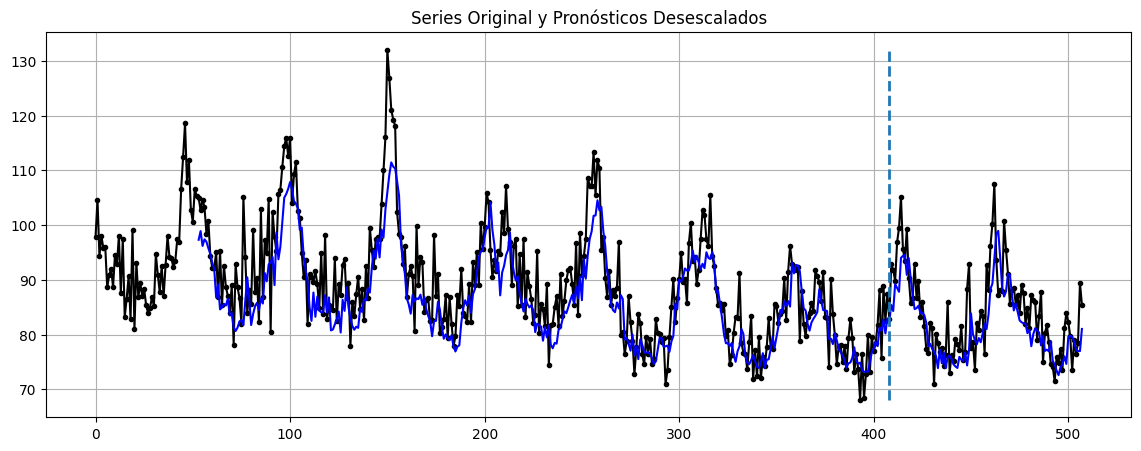

In [ ]:
# Desescalamos los datos para llevarlos a la escala original #
y_m1=scaler.inverse_transform([[u] for u in y_scaled_m1])
y_m1=[u[0] for u in y_m1]
cmort_df_list = cmort_df.values.tolist()

plt.figure(figsize=(14,5))
plt.plot(cmort_df_list, ".-k")
plt.grid()
plt.plot([None] * S + y_m1, "-b")
plt.plot([len(cmort_df_list)-100, len(cmort_df_list)-100], [min(cmort_df_list), max(cmort_df_list)], "--", linewidth=2)
plt.title("Series Original y Pronósticos Desescalados")

## Desempeño del Modelo

En este caso consideraremos las métricas MAPE y MAE.

In [ ]:
y_true = cmort_df_list[-100:]
y_pred = y_m1[-100:]

In [ ]:
# Función para calcular el MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calcular el MAPE
mape = mean_absolute_percentage_error(y_true, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

# Calcular el MAE
mae = mean_absolute_error(y_true, y_pred)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Percentage Error (MAPE): 9.343167243213616
Mean Absolute Error (MAE): 4.502467578007203


### ***EJERCICIO*** : Realizar el mismo análisis considerando la serie tranformada, es decir, a la serie $ z_t = (1-B^{52})(1-B)x_t $, y calcular las medidas de desempeño respecto al pronóstico.